<a href="https://colab.research.google.com/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Hall_of_fame_analysis/variabilitiy_analysis.ipynb">
   <img align="left" 
      src="https://colab.research.google.com/assets/colab-badge.svg">
</a>
<a href="https://mybinder.org/v2/gh/anirban6908/All-active-Manuscript/blob/master/notebooks/Hall_of_fame_analysis/variabilitiy_analysis.ipynb/master">
   <img align="left" 
      src="https://mybinder.org/badge_logo.svg">
</a>
<a href="https://nbviewer.jupyter.org/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Hall_of_fame_analysis/variabilitiy_analysis.ipynb">
   <img align="right" 
      src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" 
      width="109" height="20">
</a>

In [3]:
%matplotlib inline
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
from ateamopt.utils import utility
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from man_opt.cluster_score import gap_statistic
import man_opt.utils as man_utils
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

In [7]:
imshow_cmap = ListedColormap([(1,0,0),(1,1,0),(0,1,.45)])
least_pop_index = 6


def gridsearch_kmeans(data_,ax,max_clust_num=11):
    data_= StandardScaler().fit_transform(data_)
    clust_num_arr = range(2, max_clust_num)
    np.random.seed(0)
    gap_arr,sk_arr = [],[]
    
    for clust_ in clust_num_arr:
        estim = KMeans(n_clusters=clust_)
        gap,sk = gap_statistic(estim, data_)
        gap_arr.append(gap)
        sk_arr.append(sk)
    
    gap_arr,sk_arr = np.array(gap_arr),np.array(sk_arr)
    gap_sk = gap_arr -sk_arr
    gap_diff = gap_arr[:-1] - gap_sk[1:]
    optimal_cluster_num = clust_num_arr[np.where(gap_diff>0)[0][0]] 
    fontsize=6
    axins = inset_axes(ax, width="100%", height="100%", 
                   bbox_to_anchor=(.15, .75, .35, .25),
                    bbox_transform=ax.transAxes,loc=2)

    axins.plot(clust_num_arr, gap_arr,lw=1)
    axins.vlines(optimal_cluster_num, axins.get_ylim()[0], axins.get_ylim()[1], lw=.8)
    axins.grid(False)
    axins.set_xticks(range(2,max_clust_num,2))
    axins.set_xticklabels([str(clust) for clust in range(2,max_clust_num,2)],
                           fontsize=fontsize)
    plt.setp(axins.get_yticklabels(),fontsize=fontsize)
    axins.set_xlabel('# of clusters',fontsize=fontsize,labelpad=1)
    axins.set_ylabel('gap statistic',fontsize=fontsize,labelpad=1)  
    axins.tick_params(axis='x', pad=-3)
    axins.tick_params(axis='y', pad=-3)
    return optimal_cluster_num

def draw_kmeans_decision_boundary(data_,nclusters,ax,h=5e-2):
        
    # Plot the decision boundary. For that, we will assign a color to each
    scaler = StandardScaler()
    data_= scaler.fit_transform(data_)
    x_min, x_max = data_[:, 0].min() - 1, data_[:, 0].max() + 1
    y_min, y_max = data_[:, 1].min() - 1, data_[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    
    kmeans = KMeans(n_clusters=nclusters)
    kmeans.fit(data_)
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
    inv_scaler_transform = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    xx = inv_scaler_transform[:,0].reshape(xx.shape)
    yy = inv_scaler_transform[:,1].reshape(yy.shape)
    Z = Z.reshape(xx.shape)
    Z_rearranged = np.zeros_like(Z) 
    
    # this part is specific to 3 clusters and the structure
    print('Decision boundary plotting code is specific to the cluster structure and n_clusters = 3')
    Z_corners = [Z[0,0],Z[0,-1],Z[-1,-1]]
    for i,z_val in enumerate(Z_corners):
        Z_rearranged[Z==z_val] = i
    
    ax.imshow(Z_rearranged, interpolation='nearest',
       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
       cmap=imshow_cmap,alpha=.1,
       aspect='auto', origin='lower')
    

In [8]:
data_path = os.path.join(os.getcwd(),os.pardir,os.pardir,'assets','aggregated_data')
mouse_data_filename = os.path.join(data_path,'Mouse_class_data.csv')
mouse_datatype_filename = os.path.join(data_path,'Mouse_class_datatype.csv')
train_ephys_max_amp_filename = os.path.join(data_path,'train_ephys_max_amp.csv')
train_ephys_max_amp_dtype_filename = os.path.join(data_path,'train_ephys_max_amp_dtype.csv')
train_ephys_max_amp_fields_filename = os.path.join(data_path,'train_ephys_max_amp_fields.json')
hof_model_ephys_max_amp_filename = os.path.join(data_path,'hof_model_ephys_max_amp.csv')
hof_model_ephys_max_amp_dtype_filename = os.path.join(data_path,
                                              'hof_model_ephys_max_amp_datatype.csv')

cre_coloring_filename = os.path.join(data_path,'rnaseq_sorted_cre.pkl')

mouse_data_df = man_utils.read_csv_with_dtype(mouse_data_filename,mouse_datatype_filename)
bcre_cluster = mouse_data_df.loc[mouse_data_df.hof_index==0,['Cell_id','Broad_Cre_line']]

ephys_data = man_utils.read_csv_with_dtype(train_ephys_max_amp_filename,
                                                  train_ephys_max_amp_dtype_filename)
model_ephys_data = man_utils.read_csv_with_dtype(hof_model_ephys_max_amp_filename,
                                                  hof_model_ephys_max_amp_dtype_filename)

cre_color_dict = utility.load_pickle(cre_coloring_filename)
bcre_order = ['Htr3a','Sst','Pvalb','Pyr']
bcre_dict = {'Pyr':'Rbp4-Cre_KL100','Pvalb':'Pvalb-IRES-Cre',
             'Sst':'Sst-IRES-Cre','Htr3a':'Htr3a-Cre_NO152'}
bcre_colors = [cre_color_dict[bcre_dict[bcre_]]
        for bcre_ in bcre_order]
cmap = ListedColormap(bcre_colors)

Decision boundary plotting code is specific to the cluster structure and n_clusters = 3
Decision boundary plotting code is specific to the cluster structure and n_clusters = 3
Decision boundary plotting code is specific to the cluster structure and n_clusters = 3


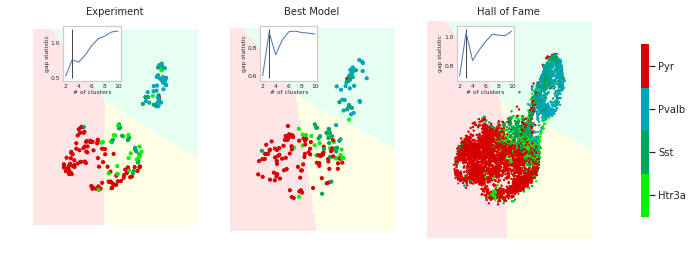

In [9]:
target_field = 'Broad_Cre_line'
efeat_max_df = ephys_data.drop(labels=['stim_name','amp'],axis=1)
df_umap_efeat_max = pd.merge(efeat_max_df,bcre_cluster,how='left',
                            on='Cell_id')
X_df,y_df,revised_features = man_utils.prepare_data_clf\
                            (df_umap_efeat_max,list(efeat_max_df),target_field,
                             least_pop=least_pop_index)
ephys_features = [feature_ for feature_ in revised_features \
                         if feature_ != 'Cell_id']                            

X_data = X_df.loc[:,ephys_features].values
y_df['label_encoder']= y_df[target_field].apply(lambda x:bcre_order.index(x))
                            

# UMAP pipeline
umap_pipeline = Pipeline([
                ('scaling', StandardScaler()), 
                ('umap',UMAP(n_neighbors=10,random_state=0))])


# Fit UMAP (on experimental features)
umap_ = umap_pipeline.fit(X_data) # Experimental ephys
data_exp = pd.concat([X_df,y_df],axis=1)
data_exp['x-umap'] = umap_.named_steps['umap'].embedding_[:,0]
data_exp['y-umap'] = umap_.named_steps['umap'].embedding_[:,1]


# Transform new data (Features of all hof models)
df_tsne_model_efeat_max = pd.merge(model_ephys_data,bcre_cluster,how='left',
                                on='Cell_id')
mephys_X_df,mephys_y_df,revised_features = man_utils.prepare_data_clf\
                                (df_tsne_model_efeat_max,list(model_ephys_data),
                                 target_field,least_pop=40*least_pop_index)
e_features = [feature_ for feature_ in revised_features \
                         if feature_ not in ['Cell_id','hof_index']]

hof_ephys_data = mephys_X_df.loc[:,e_features].values
mephys_y_df['label_encoder']= mephys_y_df[target_field].apply(lambda x:bcre_order.index(x))
hof_data = pd.concat([mephys_X_df,mephys_y_df],axis=1)

hof_transform = umap_pipeline.transform(hof_ephys_data)
hof_data['x-umap'] = hof_transform[:,0]
hof_data['y-umap'] = hof_transform[:,1]

title_list = ['Experiment', 'Best Model', 'Hall of Fame']

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0,len(bcre_order)-1))
sm.set_array([])
figname='figures/umap_ephys.svg' 
utility.create_filepath(figname)
axis_fontsize=10
sns.set(style='whitegrid')
fig,ax = plt.subplots(1,3,sharey=True,figsize=(10,4))
ax[0].scatter(data_exp['x-umap'], data_exp['y-umap'], s= 10, c=data_exp['label_encoder'],
            cmap=cmap)
nclusters = gridsearch_kmeans(data_exp.loc[:,['x-umap','y-umap']].values,ax[0])
draw_kmeans_decision_boundary(data_exp.loc[:,['x-umap','y-umap']].values,nclusters,ax[0])

ax[1].scatter(hof_data.loc[hof_data.hof_index==0,'x-umap'], 
          hof_data.loc[hof_data.hof_index==0,'y-umap'], s= 10, c=hof_data.loc[hof_data.hof_index==0,
          'label_encoder'],cmap=cmap)
nclusters=gridsearch_kmeans(hof_data.loc[hof_data.hof_index==0,['x-umap','y-umap']].values,ax[1])
draw_kmeans_decision_boundary(hof_data.loc[hof_data.hof_index==0,['x-umap','y-umap']].values,
                              nclusters,ax[1])
ax[2].scatter(hof_data['x-umap'], hof_data['y-umap'], s= 2, c=hof_data['label_encoder'],
            cmap=cmap)
nclusters=gridsearch_kmeans(hof_data.loc[:,['x-umap','y-umap']].values,ax[2])
draw_kmeans_decision_boundary(hof_data.loc[:,['x-umap','y-umap']].values,nclusters,ax[2])

for jj,ax_ in enumerate(ax):
    ax_.axis('off')
    ax_.set_title(title_list[jj], fontsize=axis_fontsize)
cax = fig.add_axes([0.97, 0.2, 0.01,.6])
cbar = plt.colorbar(sm,boundaries=np.arange(len(bcre_order)+1)-0.5,cax=cax)
cbar.set_ticks(np.arange(len(bcre_order)))
cbar.ax.set_yticklabels(bcre_order, fontsize=axis_fontsize)    
cbar.outline.set_visible(False)
    
fig.savefig(figname,bbox_inches='tight')
plt.show()